# Using Word Embeddings for Semantic Analysis of Nominal Classifiers
### An exploration into using dendrogram analysis and k-means clustering for hypothesis formation

Word embeddings from Word2Vec can be utilized in exploring the semantic distributions of nouns associated with nominal classifiers.

Nominal classifiers are known to have a range of semantic values that often form a sort of semantic network reflected in the nouns with which they co-occur. This means that the co-occurring nouns will often have various semantic relationships or fall into various semantic groups that would enable us to determine the various categories found in these semantic networks. For those lacking a linguistics background, a nominal classifier is a part of speech not found in European languages, but is ubiquitous in East and Southeast Asian languages, and should not be confused with classifiers in the machine learning sense.

We can perform this exploration by comparing word embeddings of the words that co-occur with a given nominal classifier, either through a dendrogram or k-means clustering.

Here, our goal is to produce a semantic analysis of the Hmong nominal classifier _tus_.  

Ideally, we would use some form of semantic ontology-based system (e.g. WordNet) for word embeddings, but this does not yet exist for a resource-poor language like Hmong, meaning that our best option is the raw text found in the approximately 12-million-token soc.culture.hmong (SCH) corpus. 

To enable this sort of analysis, we make the following assumption: given that the word embeddings are trained based on their context in Word2Vec, and this context encodes both syntactic and semantic information, the most similar words will share both syntactic context and semantic values. At the same time, many words will be moderately similar—they may share semantic values but not many syntactic contexts (still desirable for this approach), or many syntactic contexts but not semantic values (the drawback to the approach). 

This means that as we pursue the analysis, we must remember that the word embeddings are not purely semantic, but reflect both syntactic and semantic properties of the words, and so some words will appear in certain groups because of its syntactic properties rather than semantics. Nevertheless, because in a significant portion of cases semantics will be a major determining factor for similarity, useful results emerge from this approach that provide a strong basis for hypothesis formation enabling further research, so long as the results are considered judiciously.

Let's begin.

#### Import libraries.

The first step is to import the relevant modules and classes. The NLTK library is used to manipulate the data from the corpus that we're going to use, and Word2Vec is used to convert the corpus vocabulary into vectors that can be manipulated for the analysis.

In [1]:
import os
import copy
from nltk.corpus import PlaintextCorpusReader
from nltk.collocations import BigramCollocationFinder as finder, BigramAssocMeasures as measures
from gensim.models import Word2Vec

from itertools import groupby

#### Load training corpus.

The next step is to navigate to the folder containing the raw corpus, and importing it using the `PlaintextCorpusReader` class from the `nltk.corpus` module.
The corpus we're using is the SCH Corpus, a publicly-available corpus of Hmong text that derives from forum posts online on soc.culture.hmong Usenet.

In [2]:
os.chdir(os.path.expanduser(os.path.join('~','sch_corpus')))

hmong = PlaintextCorpusReader('.', '.*').sents()

#### Train word embeddings with Word2Vec.

Next, we use the `Word2Vec` class from `gensim.models` to create our word vectors. The argument `window` is set to 10 to indicate that a window of 10 around the chosen word should be used to train the vectors. `size` is the size of the vector for each word, set here to 150 to enable a reasonably robust yet compact set of vectors. `iter` is the number of iterations used in training; here, I've set it to 50.

In [7]:
model = Word2Vec(sentences=hmong, window=10, size=150, iter=50, workers=10)

In [3]:
# remove in the final version
import pickle
os.chdir(os.path.expanduser(os.path.join(os.path.join('~', 'python_workspace'), 'hmong_clf_graph')))
f = open('Word2Vec_model_50.pkl', 'rb')
model = pickle.load(f)
f.close()

#### Carry out data preprocessing to produce a high-quality set of nouns.

This step uses BigramCollocationFinder from nltk.collocations to find all the bigram collocations in the corpus. We do this because we want to have nouns that collocate with the Hmong classifier _tus_. We save a deep copy of the bigrams for later use using `copy.copy`.

In [3]:
bigrams = finder.from_words([w for sent in hmong for w in sent])
bigrams_copy = copy.copy(bigrams)

Next, we apply several filters to limit the bigrams we're considering to only those that contain _tus_ or its variant form _tug_, and to ensure the co-occurrence is reasonably common in the corpus, since we want nouns that commonly occur with _tus_.

In [5]:
bigrams.apply_ngram_filter(lambda x, y: x.lower() not in ['tus', 'tug'])
bigrams.apply_freq_filter(20)

For this step, we draw bigram collocations from the remaining set of bigrams based on a relatively strong degree of co-occurrence, ranked by the `chi_sq` measure from `nltk.collocations.BigramAssocMeasures`. We limit the output to the 700 highest ranked bigrams based on this measure, as lower ranked members represent instances where the relationship between _tus_ and the second word is not particularly strong.
Then we extract out only the second members from each collocation-chi_sq score pair, as the first will be the classifier _tus_ itself.

In [6]:
out = bigrams.score_ngrams(measures.chi_sq)[:700]
out_proc = [w[0][1] for w in out]

Then, we select out the 500 most common bigrams in the entire corpus, extract the nouns from the collocation-frequency pairs, and take the lowercase versions of each one. Then we limit our set of nouns to consider based on their presence both in the 500 most common bigrams list, as well as the list of 700 with the highest chi squared score. This ensures a balance between the most common nouns with _tus_ in the corpus and those that more strongly correlate with _tus_ in particular.

In [7]:
finds = bigrams.ngram_fd.most_common(500)
finds_proc = [w[0][1] for w in finds]
finds_proc_lower = [w.lower() for w in finds_proc]
total_proc = [w.lower() for w in out_proc if w in finds_proc_lower]

Next we need to clean the list of nouns we're considering to only include what are obviously nouns, only full words, and only nouns from White Hmong. For languages with better available resources, we would use a POS tagger at an earlier stage of the process, where this would be done automatically; here, a list of non-nouns in our set has been manually provided.

In Hmong, classifiers like _tus_ can be followed by content that are not nouns, such as relative clauses or localizers—that is, a special class of words indicating relative spatial position common in Asian languages; in these cases, the noun is either omitted or is zero.

Also, Hmong has two common orthographies: one that puts spaces between _syllables_, and another that puts spaces between _words_. As a result, we need to remove all syllables that are not complete words, selecting only those that are complete words.

Finally, the SCH corpus contains data from both White Hmong and Green Mong. This will create confusion in our analysis, so we explicitly limit our nouns to those from White Hmong.

In [8]:
non_nouns_to_exclude = ['puav', 'me', 'hluas', 'kws', 'laus', 'twg', 'uas', \
                        'laug', 'ub', 'mos2', '22', 'hlob', 'loj', 'coj', '.', ',', \
                        'ntawd', 'yog', 'tod', 'swb', 'li', 'tuag', '#', 'sau', \
                        'niag', 'tias', 'lawm', 'ib', 'mos', 'muab', '/', 'muaj', \
                        'nrog', 'rau', 'luag', 'ua', 'los', 'nws', 'txawm', 'hais', \
                        'thaum', 'lawv', 'tsi', 'es', 'phem', 'nuav', 'tej', 'has', \
                        'xav', 'hov', 'kuv', 'ces', 'ntawm', 'tawm', 'lwm', '(', 'kiag',\
                        'hu', 'cov', 'ntseeg', 'mus', 'ko', 'mas', 'tiag', 'to', \
                        'yam', 'tag', 'nawb', 'pom', 'miv', 'no', 'peb', 'sib', 'hlub', \
                        'twb', 'thiab', 'pab', 'leej', 'tsis', '...', 'kawg', 'kom', \
                        'xwb', 'tau', 'tshiab', 'noj', 'tus', 'qub', 'lub', 'txoj', \
                        'nyuas', 'thib', 'ntse', 'nyuag', 'thiaj', 'tshab', 'nua', 'koj',\
                        'tham', 'yau', 'tham', 'saib', 'hauv', 'yees', 'teb', 'luj', \
                        'txiav', 'tswj', 'xub', 'thaub', 'cuav', 'puas', 'txheeb', 'puag', \
                        'ruam', 'siab', 'tsim', 'pluag', 'yus', 'tuav', 'rog', 'txawj',\
                        'mob', 'tub']
partial_words_to_exclude = ['poj', 'tij', 'quas', 'xf', 'dr', 'ntsuj', 'tib', 'tuab', \
                            'teeb', 'yeeb', 'xeeb', 'kas', 'cawm', 'zuj', 'npau', 'cuj',\
                            'cwj', 'xov', 'kav', 'kab', 'txheej', 'xib', 'huab', 'pej',\
                            'phooj']
green_mong_to_exclude = ['mivnyuas', 'nam', 'dlaab', 'puj', 'moob', 'tuabneeg', 'quasyawg',\
                         'quaspuj', 'dlev', 'tsaj', 'nav', 'qab']
total_proc = [w for w in total_proc if w not in non_nouns_to_exclude]
total_proc = [w for w in total_proc if w not in partial_words_to_exclude]
total_proc = [w for w in total_proc if w not in green_mong_to_exclude]
total_proc = list(set(total_proc))

The next step provides English glosses for the Hmong words, for readers' convenience.

In [9]:
total_proc_english = ['stick', 'director', 'animal', 'hook', 'aunt', 'scent', 'price', 'brothers', 'pastor', 'doctor',\
                     'money', 'crossbow', 'grandfather', 'policy', 'judge', 'pig', 'human being', 'God', 'fish',\
                     'phallus', 'spirit', 'flag', 'responsibility', 'grandmother', 'water buffalo', 'behavior',\
                     'boss', 'email', 'person', 'finger', 'friend', 'bird', 'boss', 'soul', 'marriage negotiator',\
                     'creator god', 'daughter-in-law', 'form', 'tree trunk', 'cousin', 'cow', 'brother', 'member',\
                     'uncle', 'bridge', 'wife', 'system', 'leader', 'daughter', 'politician', 'enemy', 'leader', 'leader',\
                     'way', 'characteristic', 'brother', 'mother', 'government official', 'rib', 'chicken', 'grandfather',\
                     'symbol', 'tongue', 'man', 'brother', 'pillar', 'young woman', 'servant', 'horse', 'oneself',\
                     'phone', 'sister', 'Hmong', 'seed', 'snake', 'image', 'dog', 'root', 'river', 'letter', 'mistake',\
                     'rat', 'behavior', 'child', 'boss', 'president', 'tiger', 'female', 'father/husband', 'emperor',\
                     'bone', 'guest', 'son-in-law', 'life']
total_proc_dict = {h: e for h, e in zip(total_proc, total_proc_english)}

['dab', 'nom', 'ntxhais', 'neej', 'pog', 'nas', 'hmoob', 'muam', 'txiv', 'phone', 'nab', 'dejnum', 'huabtais', 'system', 'noob', 'dej', 'tsiaj', 'txivneej', 'nqi', 'judge', 'president', 'duab', 'txha', 'member', 'kwvtij', 'txiaj', 'npawg', 'nai', 'qhev', 'mejkoob', 'email', 'yeebncuab', 'yawm', 'kasmoos', 'npua', 'niam', 'ntxhiab', 'thawj', 'yawg', 'thawjcoj', 'doctor', 'maum', 'tibneeg', 'uncle', 'kev', 'qaib', 'hneev', 'ntses', 'phoojywg', 'pas', 'kwv', 'nus', 'ntoo', 'cag', 'kheej', 'nyab', 'neeg', 'saub', 'cujpwm', 'vauv', 'leader', 'director', 'nees', 'qhua', 'ntawv', 'nplaig', 'xibfwb', 'policy', 'tsov', 'dev', 'xeebceem', 'nkauj', 'ntiv', 'choj', 'noog', 'txhaum', 'ncej', 'vajtswv', 'twm', 'nais', 'chij', 'cwjpwm', 'tijlaug', 'tswv', 'pojniam', 'menyuam', 'qauv', 'tav', 'cim', 'nuv', 'phauj', 'plig', 'qau', 'nyuj']


Next, we retrieve the vectors from the model for the resulting set of nouns we've chosen.

In [10]:
total_proc_vectors = [model.wv[w] for w in total_proc]

#### Plotting the dendrogram.

To plot a dendrogram, we need to import `matplotlib` and the `dendrogram` and `linkage` classes from `scipy.cluster.hierarchy`.

In [8]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Now, we plot the final dendrogram. The first step is to create a linkage object containing our noun vector list. Then we plot the figure using `matplotlib.pyplot` and the `dendrogram` class. We use `leaf_font_size` to set the font size of the labels in the plot, and `leaf_rotation` to ensure the labels for each noun are rotated vertically to ensure they are legible. The final item, `leaf_label_func`, is defined with a <span style="color:green;font-weight:bold;">lambda</span> function, where a label is mapped to the word in our noun list `total_proc` that corresponds to the vector in the noun vector list `total_proc_vectors`.

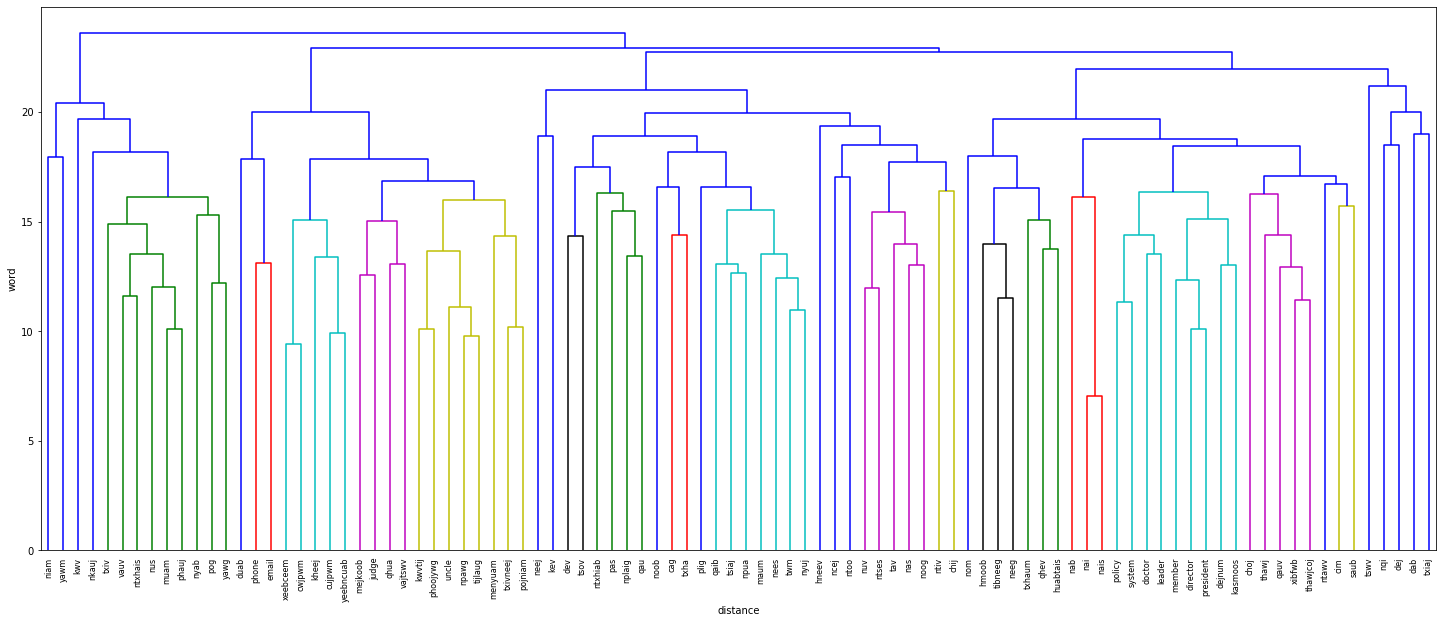

In [27]:
l = linkage(total_proc_vectors, method='complete', metric='seuclidean')
plt.figure(figsize=(25,10))
plt.ylabel('word')
plt.xlabel('distance')
dendrogram(l, leaf_font_size=8., leaf_rotation=90., leaf_label_func=lambda v: total_proc[v])
plt.show()

The dendrogram groups primarily family and other relational terms on the left in blue and green, including _niam_ 'mother', _yawm_ 'grandmother', _txiv_ 'father', and _vauv_ 'son-in-law', with an additional group in mustard yellow, including _kwvtij_ 'male siblings' and _phoojywg_ 'friend(s)'. 

A group of fairly abstract terms related to humans appears in cyan toward the left, including _cwjpwm_ 'behavior' and _kheej_ 'oneself'. Terms for human social roles appears in purple toward the left, such as the English borrowing _judge_ and _qhua_ 'guest', while an additional grouping dominated by English loans representing professional roles appears in cyan near the right, including _doctor_ and _leader_, though notably, abstract English-sourced terms are grouped with these. As stated above, this is a result of the nature of the source corpus, which produces word embeddings that reflect a range of relationships, not merely semantic.

Two large groupings of animals also appears, including the cyan group near the center containing primarily domesticated farm animals such as _qaib_ 'chicken', _npua_ 'pig', and _nyuj_ 'cow', and the purple group to the right of center containing small, canonically wild animals such as _ntses_ 'fish', _nas_ 'rat', and _noog_ 'bird'.

Modes of communication also receive their own grouping, as with _phone_, _email_, and _duab_ 'picture' in red and blue toward the left.

Finally, _ncej_ 'pillar' and _ntoo_ 'tree, wood' are grouped together in blue to the right of center.

One drawback of the dendrogram approach in general, of course, is how groupings are made: more sensible groupings at the macro level may be missed because of the groupings already made at the lower levels. What we see here, however, is that while there are still a number of nouns that appear in unexpected groupings, large, mostly sensible semantic categories still dominate the results: human family terms, human abstract terms, human social roles (especially English-sourced professional ones), domesticated farm animals, small wild animals, methods of communication, and cylindrical wooden things. These categories can serve as a foundational hypothesis for further research, which is exactly our goal here.

#### K-Means Clustering

Next, we'll do a k-means clustering analysis of the word embeddings of the nouns.

As with the dendrogram approach above, the k-means clustering approach will still be sensitive to non-semantic features of the word embeddings. Nevertheless, we should still find robust clusters in the results that will serve well in hypothesis formation driving further research.

We begin by importing the necessary libraries. K-means clustering is enabled by `sklearn.cluster.KMeans`.

In [13]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

Next, we train the k-means clustering model. We choose seven clusters here as it produces groupings that are impressionistically the most semantically sensible, as we will see below. Given the use of word embeddings from the SCH corpus, useful approaches to determine the best k value such as the elbow method or silhouette clustering are not particularly helpful for our purposes, as their results rely on the full range of what is encoded in the embeddings rather than semantics alone.

In [49]:
km = KMeans(n_clusters=7, init='random', n_init=30, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(total_proc_vectors)

Next, let's look at the groupings.

In [50]:
outcomes = zip(y_km, total_proc, total_proc_english)
total_proc_grouped = groupby(sorted(outcomes, key=lambda x: x[0]), lambda x: x[0])
for key, group in total_proc_grouped:
    print(key)
    for item in group:
        print(item[1], "'" + item[2] + "'")
    print()

0
nqi 'price'
txiaj 'money'
tibneeg 'human being'
vajtswv 'God'
dab 'spirit'
dejnum 'responsibility'
neeg 'person'
mejkoob 'marriage negotiator'
choj 'bridge'
pojniam 'wife'
kev 'way'
hmoob 'Hmong'
duab 'image'
dej 'river'
txhaum 'mistake'
menyuam 'child'
neej 'life'

1
xibfwb 'pastor'
doctor 'doctor'
yawg 'grandfather'
chij 'flag'
tswv 'boss'
nai 'boss'
plig 'soul'
saub 'creator god'
nyab 'daughter-in-law'
thawj 'leader'
nom 'government official'
yawm 'grandfather'
qhev 'servant'
nab 'snake'
ntawv 'letter'
nais 'boss'
huabtais 'emperor'

2
niam 'mother'

3
pas 'stick'
nuv 'hook'
hneev 'crossbow'
ntses 'fish'
qau 'phallus'
ntiv 'finger'
ntoo 'tree trunk'
tav 'rib'
nplaig 'tongue'
ncej 'pillar'
noob 'seed'
cag 'root'
nas 'rat'
txha 'bone'

4
director 'director'
policy 'policy'
judge 'judge'
cujpwm 'behavior'
email 'email'
qauv 'form'
member 'member'
system 'system'
thawjcoj 'leader'
kasmoos 'politician'
yeebncuab 'enemy'
leader 'leader'
xeebceem 'characteristic'
cim 'symbol'
txivneej 'm

With seven groups, the results are interesting. 

While group 0 has an unclear semantic basis—likely reflecting non-semantic information or other idiosyncratic relationships encoded in the word embeddings—group 1 is dominated by terms that refer to people with authority: _xibfwb_ 'pastor', _nai_ 'boss', _nom_ 'government official', and _huabtais_ 'emperor', for example. 

Group 3 likewise has mostly inanimate objects on the one hand—_pas_ 'stick', _nuv_ 'hook', _ntoo_ 'tree trunk'— and body parts on the other—_nplaig_ 'tongue' and _txha_ 'bone', for example. 

Group 4 has English borrowings related to official and other professional concepts, including occupations, such as _director_, _judge_, _system_, and _policy_, some abstract Hmong terms—probably associated with official concepts—such as _xeebceem_ 'characteristic' and _cwjpwm_ 'behavior'.

Group 5 is almost a perfect fit for relationships—_phauj_ 'aunt', _kwvtij_ 'brothers', _phoojywg_ 'friend', and so on—while _niam_ 'mother' is alone in group 2 and _noog_ 'bird' is inexplicably in group 5.

Group 6 is almost exclusively animal terms—_tsiaj_ 'animal', _npua_ 'pig', _twm_ 'water buffalo'—except for _ntxhiab_ 'scent', which makes sense as a term associated with animals.

The results from the k-means clustering approach are a sensible starting point for hypothesis formation. Obvious categories include 1) inanimate objects characterized by a straight, rigid shape, 2) similarly "straight" body parts, 3) official concepts, 4) professional roles, 5) professional concepts, 6) relationships, and 7) animals. The following words present special difficulty for this taxonomy of seven categories, and, unsurprisingly, were grouped together as a sort of "other" category as group 0 above: _nqi_ 'price', _duab_ 'image', _dej_ 'river', _txhaum_ 'mistake', _neej_ 'life', _txiaj_ 'money', _chij_ 'flag', _ntawv_ 'letter', and _noob_ 'seed'. This can be explained, however, by the fact that the relationship between these items and the larger categories are the likely result of literal and metaphorical, but idiosyncratic, semantic extensions, in addition to the combination of various forms of information reflected in the word embeddings.

#### Comparison of results

The dendrogram approach produced evidence for the following groupings:
1. human family terms
2. human abstract terms
3. human social roles (especially English-sourced professional ones)
4. domesticated farm animals
5. small wild animals
6. methods of communication
7. cylindrical wooden things

The k-means clustering approach likewise produced evidence for these groupings:
1. inanimate objects characterized by a straight, rigid shape
2. similarly "straight" body parts
3. official concepts
4. professional roles
5. professional concepts
6. human relationships
7. animals

Altogether, human terms related to family, society, and professional roles, animal terms, and straight, rigid inanimate objects were uncovered as groupings by both approaches. Furthermore, official/professional concepts, "straight" body parts, and methods of communication were groupings found in one of the approaches.

#### The Results as Hypotheses

The above results provide a strong basis for forming hypotheses for the semantic categories associated with the classifier _tus_. Below, we try new nouns not seen in the analyses above to check our categories. Let's try _xeebntxwv_ 'grandchild' as a human family term, _neeb_ 'shaman' as a human society term, _dais_ 'bear' for an animal term, and _cav_ 'log, pole' for a straight, rigid inanimate object term.

We check for the co-occurrence of these with _tus_ in terms of raw frequency in the `bigrams_copy` that we created above.

In [10]:
print("tus xeebntxwv 'the grandchild': ", bigrams_copy.ngram_fd[('tus', 'xeebntxwv')])
print("tus neeb 'the shaman': ", bigrams_copy.ngram_fd[('tus', 'neeb')])
print("tus dais 'the bear': ", bigrams_copy.ngram_fd[('tus', 'dais')])
print("tus cav 'the pole': ", bigrams_copy.ngram_fd[('tus', 'cav')])

tus xeebntxwv 'the grandchild':  5
tus neeb 'the shaman':  17
tus dais 'the bear':  8
tus cav 'the pole':  16


These four nouns show frequency of co-occurrences with _tus_ in our corpus of less than 20, meaning that they were eliminated from the analyses above by the line `bigrams.apply_freq_filter(20)` early on in the process. Nevertheless, all four of these co-occur multiple times with _tus_, suggesting that our semantic category hypotheses based on the dendrogram and k-means clustering analyses above will likely prove correct, producing useful results contributing to our goal of charting the semantic network associated with _tus_.

#### Conclusion

Taken together, the dendrogram analysis and k-means clustering approach above enable hypothesis formation for a semantic network associated with the Hmong classifier _tus_. This is significant, given the current lack of a semantic ontology for the Hmong language that should otherwise limit this sort of research, and as a result, this approach will likely prove useful in data exploration and hypothesis formation for other resource-poor languages as well.